In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from importlib import reload

In [2]:
import particle_decoding as pd

In [3]:
reload(pd)

<module 'particle_decoding' from '/Users/jim2/bin/libVAE/particle_decoding.py'>

## Transformations

In [4]:
test_coords = np.array([[[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]],
                        [[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]]])

In [5]:
pd.identity_transform(test_coords)

<tf.Tensor: shape=(2, 3, 3), dtype=float64, numpy=
array([[[ 1. ,  1. ,  1. ],
        [-1. ,  1. ,  0. ],
        [ 0.5,  0.5,  1. ]],

       [[ 1. ,  1. ,  1. ],
        [-1. ,  1. ,  0. ],
        [ 0.5,  0.5,  1. ]]])>

In [6]:
pd.spherical_transform(test_coords)

<tf.Tensor: shape=(2, 3, 3), dtype=float64, numpy=
array([[[1.73205081, 0.78539816, 0.30408672],
        [1.41421356, 2.35619449, 0.5       ],
        [1.22474487, 0.78539816, 0.19591328]],

       [[1.73205081, 0.78539816, 0.30408672],
        [1.41421356, 2.35619449, 0.5       ],
        [1.22474487, 0.78539816, 0.19591328]]])>

In [7]:
pd.spherical_transform(test_coords, dist_sq=tf.reduce_sum(test_coords * test_coords, axis=-1))

<tf.Tensor: shape=(2, 3, 3), dtype=float64, numpy=
array([[[1.73205081, 0.78539816, 0.30408672],
        [1.41421356, 2.35619449, 0.5       ],
        [1.22474487, 0.78539816, 0.19591328]],

       [[1.73205081, 0.78539816, 0.30408672],
        [1.41421356, 2.35619449, 0.5       ],
        [1.22474487, 0.78539816, 0.19591328]]])>

In [8]:
pd.spherical_transform(pd.spherical_transform(test_coords), reverse=True)

<tf.Tensor: shape=(2, 3, 3), dtype=float64, numpy=
array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [-1.00000000e+00,  1.00000000e+00,  8.65956056e-17],
        [ 5.00000000e-01,  5.00000000e-01,  1.00000000e+00]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [-1.00000000e+00,  1.00000000e+00,  8.65956056e-17],
        [ 5.00000000e-01,  5.00000000e-01,  1.00000000e+00]]])>

## Masking by distance

In [9]:
test_coords = np.array([[[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]],
                        [[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]]])

ref_coords = np.array([[[0.0, 0.0, 0.0]],
                       [[0.0, 0.0, 1.0]]])

In [10]:
distance_mask = pd.DistanceMask()

In [11]:
distance_mask(ref_coords, test_coords, k_neighbors=2)

(<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
 array([[[ 0.5,  0.5,  1. ],
         [-1. ,  1. ,  0. ]],
 
        [[ 0.5,  0.5,  0. ],
         [ 1. ,  1. ,  0. ]]])>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[2, 1],
        [2, 0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1.5, 2. ],
        [0.5, 2. ]])>)

In [12]:
local_coords, near_inds, dist_sq = distance_mask(ref_coords, test_coords, k_neighbors=2)
pd.spherical_transform(local_coords, dist_sq=dist_sq)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[1.22474487, 0.78539816, 0.19591328],
        [1.41421356, 2.35619449, 0.5       ]],

       [[0.70710678, 0.78539816, 0.5       ],
        [1.41421356, 0.78539816, 0.5       ]]])>

In [13]:
#Need to also test if ref included in input coordinates
ref_coords = np.array([[[-1.0, 1.0, 0.0]],
                       [[1.0, 1.0, 1.0]]])

distance_mask(ref_coords, test_coords, k_neighbors=1, ref_included=True)

(<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
 array([[[ 1.5, -0.5,  1. ]],
 
        [[-0.5, -0.5,  0. ]]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[2],
        [2]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[3.5],
        [0.5]])>)

In [14]:
distance_mask(ref_coords, test_coords, k_neighbors=1, ref_included=False)

(<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
 array([[[0., 0., 0.]],
 
        [[0., 0., 0.]]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1],
        [0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[-0.],
        [-0.]])>)

In [15]:
#Now try distances with a periodic simulation box
test_coords = np.array([[[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]],
                        [[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]]])

ref_coords = np.array([[[0.0, 0.0, 0.0]],
                       [[0.0, 0.0, 1.0]]])

distance_mask = pd.DistanceMask(box_lengths=np.array([3.0, 3.0, 3.0]))

In [16]:
distance_mask(ref_coords, test_coords, k_neighbors=2)

(<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
 array([[[ 0.5,  0.5,  1. ],
         [-1. ,  1. ,  0. ]],
 
        [[ 0.5,  0.5,  0. ],
         [ 1. ,  1. ,  0. ]]])>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[2, 1],
        [2, 0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1.5, 2. ],
        [0.5, 2. ]])>)

In [17]:
local_coords, near_inds, dist_sq = distance_mask(ref_coords, test_coords, k_neighbors=2)
pd.spherical_transform(local_coords, dist_sq=dist_sq)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[1.22474487, 0.78539816, 0.19591328],
        [1.41421356, 2.35619449, 0.5       ]],

       [[0.70710678, 0.78539816, 0.5       ],
        [1.41421356, 0.78539816, 0.5       ]]])>

In [18]:
#Need to also test if ref included in input coordinates
ref_coords = np.array([[[-1.0, 1.0, 0.0]],
                       [[1.0, 1.0, 1.0]]])

distance_mask(ref_coords, test_coords, k_neighbors=1, ref_included=True)

(<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
 array([[[-1. ,  0. ,  1. ]],
 
        [[-0.5, -0.5,  0. ]]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[0],
        [2]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[2. ],
        [0.5]])>)

In [19]:
distance_mask(ref_coords, test_coords, k_neighbors=1, ref_included=False)

(<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
 array([[[0., 0., 0.]],
 
        [[0., 0., 0.]]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1],
        [0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[-0.],
        [-0.]])>)

## Creating probability distributions

In [20]:
params = np.array([[[[0.0, 1.0], [10.0, 1.0], [-10.0, 1.0]],
                    [[0.0, 1.0], [0.0, 2.0], [0.0, 10.0]],
                    [[5.0, 1.0], [5.0, 2.0], [5.0, 10.0]]],
                   [[[0.0, 1.0], [-10.0, 1.0], [10.0, 1.0]],
                    [[0.0, 10.0], [0.0, 2.0], [0.0, 1.0]],
                    [[-5.0, 10.0], [-5.0, 2.0], [-5.0, 1.0]]]])

dist_list = [tfp.distributions.Normal]*3
param_trans = [lambda x, y: [x, y]]*3

In [21]:
joint_dist = pd.create_dist(params, dist_list, param_trans)

In [22]:
sample = tf.stack(joint_dist.sample(), axis=-1)
print(sample)

tf.Tensor(
[[[-1.4957864   8.43628121 -9.54817728]
  [ 1.02861349  2.92291736 17.394667  ]
  [ 4.98729214  8.5383005  -6.01556789]]

 [[ 0.56399999 -9.92753554 10.202109  ]
  [-5.02782635  0.07759204  0.99201017]
  [ 6.58005522 -2.6620057  -3.78507813]]], shape=(2, 3, 3), dtype=float64)


In [23]:
joint_dist.log_prob(tf.unstack(sample, axis=-1))

<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[-5.20018418, -8.86237366, -7.9242886 ],
       [-2.93891317, -6.37173772, -7.84433101]])>

In [24]:
np.sum(-0.5*((sample[-1, 1, :] - params[-1, 1, :, 0])**2)/(params[-1, 1, :, 1]**2) - np.log(params[-1, 1, :, 1]) - 0.5*np.log(2.0*np.pi))

-6.371737719815245

## Solvation neural networks

In [25]:
#Input can be solute or solvent coordinates, with extra_inputs being the other
#Start by testing without augmented input (only relevant for first network to predict layer of solvent for first solute)
solute_net = pd.SolvationNet((8, 3), out_event_dims=2, hidden_dim=50, n_hidden=3, augment_input=False)

In [26]:
solute_coords = tf.random.normal((1, 2, 3))

In [27]:
params, shifts = solute_net(solute_coords)
print(params, shifts)

tf.Tensor(
[[[[ 9.43202451e-02 -5.17831091e-03]
   [-5.22761419e-02 -6.61916062e-02]
   [ 3.28886993e-02  7.28672519e-02]]

  [[-3.41968417e-01 -7.77181238e-02]
   [ 2.32752338e-02 -2.96145380e-01]
   [ 2.63412520e-02  3.73558775e-02]]

  [[-1.70728430e-01 -1.14565887e-01]
   [-7.46110752e-02  2.66379211e-04]
   [ 3.18279862e-02  2.72473432e-02]]

  [[-7.18012527e-02 -1.41824707e-01]
   [ 1.19946979e-01 -2.12319568e-01]
   [-9.18870941e-02  1.55834988e-01]]

  [[ 6.49675950e-02  3.70446384e-01]
   [ 2.26579383e-01 -7.07263499e-02]
   [-1.04562320e-01  1.62320629e-01]]

  [[ 6.23581558e-02 -4.96139005e-02]
   [-3.40832360e-02  1.13590196e-01]
   [-1.24321535e-01  1.01077825e-01]]

  [[ 1.75076365e-01 -2.42355429e-02]
   [-1.56932529e-02  1.91716298e-01]
   [ 1.97607711e-01 -6.62246719e-02]]

  [[-2.20717937e-01  5.59962960e-03]
   [ 1.14538006e-01  1.54385597e-01]
   [-1.11436620e-02  1.09353371e-01]]]], shape=(1, 8, 3, 2), dtype=float32) tf.Tensor(
[[[[-0.20642282 -0.38362554]
   [-0.4

In [28]:
dist = pd.create_dist(params + shifts, [tfp.distributions.Normal]*3, [lambda x, y: [x, tf.math.exp(0.5*y)]]*3)
sample = tf.stack(dist.sample(), axis=-1)
print(sample)

tf.Tensor(
[[[ 0.4229011  -2.143738   -0.89361095]
  [ 0.49057853  1.3259029   0.05405466]
  [-0.80037576  0.54081273 -0.90847677]
  [ 0.13004391  0.8395778  -0.5676029 ]
  [-0.89490426  1.3410827  -1.4141965 ]
  [-3.6444726  -0.5329795  -0.590726  ]
  [ 0.8222052  -1.9595196   1.1843084 ]
  [ 2.2043853  -0.89421546  0.43353698]]], shape=(1, 8, 3), dtype=float32)


In [29]:
#First set of 3 (first particle) should not change shifts, even with different input due to autoregressive
#All others should change, though
new_shifts = solute_net(solute_coords, sampled_input=sample)
print(new_shifts)

tf.Tensor(
[[[[-0.20642282 -0.38362554]
   [-0.44063586  0.10353348]
   [-0.43110064 -0.3146862 ]]

  [[ 0.14968807  0.2411887 ]
   [ 0.26814234  0.23657402]
   [ 0.14695546  0.31620598]]

  [[ 0.01348157  0.30554503]
   [ 0.3235168  -0.35089618]
   [ 0.01708116 -0.1585012 ]]

  [[-0.11330212  0.33977428]
   [ 0.5307667   0.16894601]
   [ 0.10281368  0.23936674]]

  [[ 0.06767958  0.4125022 ]
   [ 0.4844664  -0.28342003]
   [ 0.40443137 -0.6159132 ]]

  [[-0.7460314   0.14701015]
   [-0.24320069 -0.293214  ]
   [ 0.18880996  0.2069977 ]]

  [[ 0.35624993  0.13795152]
   [-0.01854382  0.31897736]
   [ 0.79691935  0.70667005]]

  [[ 0.88161874  0.12645772]
   [ 0.28163454  0.54584587]
   [-0.15233918 -0.45286924]]]], shape=(1, 8, 3, 2), dtype=float32)


In [30]:
#And now with solvent inputs (remember, could flip if wanted)
solute_net_solv = pd.SolvationNet((8, 3), out_event_dims=2, hidden_dim=50, n_hidden=3, augment_input=True)

In [31]:
solvent_coords = tf.random.normal((1, 6, 3))

In [32]:
params, shifts = solute_net_solv(solute_coords, extra_coords=solvent_coords)
print(params, shifts)

tf.Tensor(
[[[[ 0.20076025  0.46529728]
   [-0.05543216 -0.05376775]
   [ 0.15843295  0.14997846]]

  [[-0.23209828  0.33887687]
   [-0.21818705  0.03184571]
   [ 0.04642672  0.09583461]]

  [[-0.05310133  0.3770662 ]
   [ 0.02920237  0.13228893]
   [-0.19421566  0.38748842]]

  [[ 0.06684021  0.03204273]
   [-0.00226888  0.02351181]
   [ 0.03290529 -0.0256334 ]]

  [[-0.06174847 -0.22157772]
   [-0.21316825  0.12978983]
   [ 0.02228296 -0.18418604]]

  [[ 0.15337369 -0.07285701]
   [-0.11751778  0.11076088]
   [ 0.2574362   0.57451504]]

  [[-0.2300038   0.19338702]
   [ 0.26091814 -0.25521246]
   [ 0.37108445  0.2843279 ]]

  [[ 0.21009114 -0.04488233]
   [-0.0747535   0.16193712]
   [ 0.35722497 -0.18522854]]]], shape=(1, 8, 3, 2), dtype=float32) tf.Tensor(
[[[[ 0.59839344  0.21366343]
   [-1.0919954   0.46603167]
   [-0.3728853   0.5875197 ]]

  [[ 1.3912678  -0.10237261]
   [ 0.10118491  0.04839331]
   [-0.15322019  0.17803106]]

  [[ 1.4894928  -0.55140996]
   [-0.99348325  0.437

In [33]:
dist = pd.create_dist(params + shifts, [tfp.distributions.Normal]*3, [lambda x, y: [x, tf.math.exp(0.5*y)]]*3)
sample = tf.stack(dist.sample(), axis=-1)
print(sample)

tf.Tensor(
[[[ 1.0421518  -1.5143886  -1.0258077 ]
  [ 2.2527559  -2.087582    0.0707844 ]
  [ 1.6502392  -1.8884369  -1.1205738 ]
  [-1.1116261   0.3143893  -0.6753802 ]
  [-1.2255406   0.12556493 -0.50181985]
  [ 1.5363876  -1.967828    0.03148525]
  [-0.45557526 -0.61176544 -0.6088223 ]
  [ 2.0125575  -0.5591047  -2.9087954 ]]], shape=(1, 8, 3), dtype=float32)


In [34]:
new_shifts = solute_net_solv(solute_coords, extra_coords=solvent_coords, sampled_input=sample)
print(new_shifts)

tf.Tensor(
[[[[ 0.59839344  0.21366343]
   [-1.0919954   0.46603167]
   [-0.3728853   0.5875197 ]]

  [[ 1.3605595  -0.10652816]
   [ 0.12838283  0.05780311]
   [-0.17115968  0.18368438]]

  [[ 1.4447966  -0.5441421 ]
   [-0.9839839   0.43499956]
   [-0.30148232 -0.15751241]]

  [[ 0.20210885  0.6375715 ]
   [-0.70297194 -0.15961003]
   [ 0.09762785  0.48936114]]

  [[-0.80028635 -1.205637  ]
   [-0.73777544  1.0031537 ]
   [-0.6173167  -0.60092616]]

  [[ 0.4124704  -1.4011533 ]
   [ 0.15799561  1.2367927 ]
   [-0.19175729  0.12243563]]

  [[ 0.15340585 -0.9072283 ]
   [-1.0629545   0.37609753]
   [-0.711072    0.4627338 ]]

  [[-0.32382026  0.17676646]
   [ 0.13641249 -0.9698287 ]
   [-1.1438113   0.77338815]]]], shape=(1, 8, 3, 2), dtype=float32)


In [35]:
#Now that it's been called (so built) with extra_coords provided, must provide always with this layer
new_shifts = solute_net_solv(solute_coords, sampled_input=sample)
print(new_shifts)

ValueError: Input 0 of layer dense_18 is incompatible with the layer: expected axis -1 of input shape to have value 24 but received input with shape (1, 6)

In [36]:
#Now pretend we're working with a central solvent particle and adding one more
#(conditioned on other solutes and solvent already around)
solvent_net = pd.SolvationNet((1, 3), out_event_dims=2, hidden_dim=50, n_hidden=3, augment_input=True)

In [37]:
params, shifts = solvent_net(solvent_coords, extra_coords=solute_coords)
print(params, shifts)

tf.Tensor(
[[[[-0.13222116  0.00594361]
   [-0.04993698 -0.11322683]
   [-0.12802084 -0.09660713]]]], shape=(1, 1, 3, 2), dtype=float32) tf.Tensor(
[[[[-2.016705    2.2429721 ]
   [ 0.5769213  -0.44653535]
   [-0.6747737  -0.0303241 ]]]], shape=(1, 1, 3, 2), dtype=float32)


## Decimation encoding

In [38]:
test_coords = np.random.normal(size=(2, 6, 3))
test_coords

array([[[-1.86186313, -0.0222771 , -0.52088453],
        [ 0.38425667,  0.65734006,  0.51293276],
        [ 0.05253552, -0.29835377,  0.46667682],
        [-2.07195313, -0.79393357, -0.55463152],
        [-1.11161607, -2.10727655,  0.91541268],
        [-1.96865907, -0.37297254, -0.05215276]],

       [[ 1.59527046,  2.12219025, -0.48322873],
        [ 0.47170739,  0.50458105, -0.63690414],
        [-0.25620663,  0.09565954,  1.42537374],
        [-0.66340859,  0.01058814, -1.44365765],
        [-0.61680129, -0.08288094, -0.17885884],
        [ 0.94259662,  1.28425067,  0.53607183]]])

In [39]:
cg_mask = np.array([True, False, True, False, True, False])
encoder = pd.DecimationEncoder(cg_mask)

In [40]:
encoder(test_coords)

(<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[-1.8618631 , -0.0222771 , -0.5208845 ],
         [ 0.05253552, -0.29835376,  0.46667683],
         [-1.111616  , -2.1072764 ,  0.91541266]],
 
        [[ 1.5952705 ,  2.1221902 , -0.48322874],
         [-0.25620663,  0.09565954,  1.4253738 ],
         [-0.6168013 , -0.08288094, -0.17885883]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[ 0.38425666,  0.65734005,  0.5129328 ],
         [-2.071953  , -0.7939336 , -0.55463153],
         [-1.968659  , -0.37297255, -0.05215276]],
 
        [[ 0.47170737,  0.50458103, -0.6369041 ],
         [-0.6634086 ,  0.01058814, -1.4436576 ],
         [ 0.9425966 ,  1.2842506 ,  0.53607184]]], dtype=float32)>)

In [41]:
encoder = pd.DecimationEncoder(cg_mask, identical_randomize=True)
encoder(test_coords)

(<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[-1.111616  , -2.1072764 ,  0.91541266],
         [-1.8618631 , -0.0222771 , -0.5208845 ],
         [ 0.05253552, -0.29835376,  0.46667683]],
 
        [[ 1.5952705 ,  2.1221902 , -0.48322874],
         [-0.6168013 , -0.08288094, -0.17885883],
         [-0.25620663,  0.09565954,  1.4253738 ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[ 0.38425666,  0.65734005,  0.5129328 ],
         [-2.071953  , -0.7939336 , -0.55463153],
         [-1.968659  , -0.37297255, -0.05215276]],
 
        [[ 0.47170737,  0.50458103, -0.6369041 ],
         [-0.6634086 ,  0.01058814, -1.4436576 ],
         [ 0.9425966 ,  1.2842506 ,  0.53607184]]], dtype=float32)>)

## Solute decoding

In [42]:
solute_decoder = pd.SoluteDecoder(3,
                             box_lengths=np.array([3.0, 3.0, 3.0]),
                             k_solute_neighbors=3,
                             k_solvent_neighbors=3,
                             name='solutedecoder')

In [43]:
solute_coords = tf.random.uniform((2, 5, 3), minval=-1.5, maxval=1.5)

In [44]:
sample_out, params_out, ref_out, unused_data = solute_decoder(solute_coords)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 15, 3) (2, 15, 3, 2) (2, 15, 3)


In [45]:
print(unused_data)

None


In [46]:
sample_out - ref_out

<tf.Tensor: shape=(2, 15, 3), dtype=float32, numpy=
array([[[-2.7160897 ,  2.0582416 , -0.71619076],
        [ 1.4164066 ,  2.9681273 ,  2.8430152 ],
        [-1.20329   ,  0.42157036,  0.03011602],
        [ 2.9894176 , -0.7263526 , -0.30043006],
        [ 1.5138228 ,  0.46573073, -0.85691667],
        [ 0.06106079,  0.35899436,  0.67020684],
        [ 1.0108229 ,  0.7257786 ,  3.2064686 ],
        [ 0.15627676,  1.095273  , -0.47930598],
        [ 0.36921793, -0.05551675, -3.184483  ],
        [-2.3482802 , -4.2921276 , -0.90846705],
        [ 1.2887766 , -0.66787434,  2.558682  ],
        [ 1.1932961 ,  0.7423305 ,  0.85214543],
        [ 2.3808808 ,  0.449381  ,  0.6699908 ],
        [-2.247917  ,  0.95095015,  1.8266937 ],
        [-0.28707635, -1.1811022 ,  1.0333726 ]],

       [[ 0.29041052,  0.17294979, -1.6077636 ],
        [ 2.2105772 ,  1.3916838 , -0.84839725],
        [-2.2508945 , -0.30220646, -1.6860343 ],
        [-0.72702956,  3.3603501 , -0.86665773],
        [ 0.417

In [47]:
params_out

<tf.Tensor: shape=(2, 15, 3, 2), dtype=float32, numpy=
array([[[[-0.75759035,  0.36811435],
         [ 1.1524018 ,  0.18691891],
         [ 0.04818739,  0.3992896 ]],

        [[ 0.5718337 , -1.4819374 ],
         [ 1.0186124 ,  0.56738347],
         [ 0.97198766,  0.9434147 ]],

        [[ 0.40785322,  1.8586333 ],
         [ 0.5294023 ,  0.72786933],
         [-0.6186722 ,  0.9120425 ]],

        [[ 0.7308842 , -0.02693705],
         [-0.20970495,  0.6750251 ],
         [ 0.64671326, -0.08440334]],

        [[ 1.0321064 , -0.1738244 ],
         [-0.363537  ,  0.25497526],
         [-0.07573078,  0.23164728]],

        [[-0.32985902, -0.2456361 ],
         [ 1.7505039 ,  0.8844662 ],
         [ 0.87173915, -0.52843416]],

        [[ 0.28088972,  0.01863839],
         [ 0.64151895, -1.2963333 ],
         [ 0.9630431 ,  1.396128  ]],

        [[ 0.05419882, -1.3757534 ],
         [ 0.6990227 , -0.9285283 ],
         [-0.17970592, -0.8240522 ]],

        [[-0.536697  , -0.30308658],
    

In [48]:
#For convenience, added log_prob function to decoder
solute_decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 15), dtype=float32, numpy=
array([[-5.0975   , -6.099935 , -4.7957616, -6.214774 , -3.5597563,
        -3.3439271, -3.7134552, -1.5142684, -5.264424 , -5.4493933,
        -8.04944  , -2.5051584, -4.0599966, -4.616975 , -1.8698013],
       [-4.5156093, -3.6632478, -6.2919016, -6.315707 , -5.1409807,
        -2.78371  , -3.5536833, -7.6619744, -4.7486067, -4.1542645,
        -6.7902393, -4.894432 , -4.952437 , -2.2043815, -4.2430654]],
      dtype=float32)>

In [49]:
#Above tested generation, now test if have training data
training_data = tf.random.normal((2, 60, 3))

In [50]:
sample_out, params_out, ref_out, unused_data = solute_decoder(solute_coords, train_data=training_data)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 15, 3) (2, 15, 3, 2) (2, 15, 3)


In [51]:
training_data

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[-8.64837945e-01,  1.43199813e+00, -1.05170202e+00],
        [ 7.19576418e-01,  6.54484570e-01, -2.75390601e+00],
        [ 1.16697335e+00, -2.51193881e-01, -2.19542670e+00],
        [ 8.48413169e-01, -9.74475026e-01, -9.90719736e-01],
        [-3.60282242e-01,  2.64494419e-01,  2.12906814e+00],
        [-4.24370050e-01, -1.36041895e-01, -1.14805293e+00],
        [ 2.01220647e-01, -2.80286014e-01, -4.66567218e-01],
        [ 1.27501082e+00, -1.25204146e+00, -2.66906667e+00],
        [ 1.22754741e+00, -6.22774363e-01,  1.12787974e+00],
        [ 1.83214104e+00,  1.65572599e-01, -3.70024472e-01],
        [ 4.36151713e-01,  2.80713916e-01, -4.73716445e-02],
        [ 1.00560713e+00, -4.64886636e-01,  9.66766477e-01],
        [-2.30911183e+00,  6.75168216e-01, -1.66489005e+00],
        [ 3.16457152e-01, -8.29349905e-02,  6.73163235e-01],
        [-6.11661613e-01,  4.03387435e-02, -8.83475542e-01],
        [-1.20999897e+00, -6.4933

In [52]:
unused_data

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[ 7.1957642e-01,  6.5448457e-01, -2.7539060e+00],
        [ 1.1669734e+00, -2.5119388e-01, -2.1954267e+00],
        [ 8.4841317e-01, -9.7447503e-01, -9.9071974e-01],
        [-3.6028224e-01,  2.6449442e-01,  2.1290681e+00],
        [-4.2437005e-01, -1.3604189e-01, -1.1480529e+00],
        [ 1.2750108e+00, -1.2520415e+00, -2.6690667e+00],
        [ 4.3615171e-01,  2.8071392e-01, -4.7371645e-02],
        [ 1.0056071e+00, -4.6488664e-01,  9.6676648e-01],
        [-2.3091118e+00,  6.7516822e-01, -1.6648901e+00],
        [-6.1166161e-01,  4.0338743e-02, -8.8347554e-01],
        [-1.2099990e+00, -6.4933014e-01,  2.4378929e-01],
        [-1.0476623e+00, -5.3051203e-01, -5.7158482e-01],
        [ 2.0060976e+00, -5.7119614e-01,  1.7993470e+00],
        [-9.8337358e-01, -1.1224427e+00,  5.7865691e-01],
        [-3.8973451e-01, -1.0374870e+00, -3.1204098e-01],
        [ 2.6420343e-01, -1.9501151e+00, -1.1901469e+00],
        [-1.0218831e

In [53]:
sample_out

<tf.Tensor: shape=(2, 15, 3), dtype=float32, numpy=
array([[[-1.1678591 ,  0.16557258, -0.3700245 ],
        [ 0.31645715, -0.08293498,  0.67316324],
        [ 0.20122063, -0.280286  , -0.46656722],
        [-1.6979992 , -1.9341016 , -0.28042197],
        [-0.86483794, -1.5680019 , -1.051702  ],
        [ 0.5878545 , -0.4831165 , -2.4462304 ],
        [-0.11960486,  0.93079334,  0.87913704],
        [-0.5091985 ,  0.8629664 , -1.1565864 ],
        [ 0.3182274 ,  1.7207998 , -1.6307118 ],
        [ 1.2275474 , -0.62277436, -1.8721201 ],
        [ 1.7698506 , -0.0038507 , -1.9487295 ],
        [ 0.48565203,  0.8966033 ,  0.3352083 ],
        [ 0.53047746,  1.5495718 ,  0.08140248],
        [ 0.04048148,  0.99335146, -0.34001282],
        [-1.29939   ,  0.91588986, -0.75415415]],

       [[-0.15395844,  0.8809082 , -1.274098  ],
        [ 3.37058   ,  1.9617689 , -0.92153156],
        [ 2.246601  , -0.3587495 , -2.461303  ],
        [-0.17297739,  1.0172923 ,  1.1376519 ],
        [ 1.287

In [54]:
sample_out - ref_out

<tf.Tensor: shape=(2, 15, 3), dtype=float32, numpy=
array([[[-0.71045554,  0.97679096, -0.3170516 ],
        [ 0.7738607 ,  0.7282834 ,  0.72613615],
        [ 0.6586242 ,  0.53093237, -0.4135943 ],
        [-0.30685937, -0.72839177,  0.65295315],
        [ 0.5263019 , -0.36229205, -0.1183269 ],
        [ 1.9789944 ,  0.7225933 , -1.5128553 ],
        [ 0.4038261 ,  0.77899927,  2.1112752 ],
        [ 0.01423246,  0.71117234,  0.07555175],
        [ 0.84165835,  1.5690057 , -0.39857364],
        [ 0.7077205 , -0.67044795, -1.132634  ],
        [ 1.2500237 , -0.05152429, -1.2092434 ],
        [-0.03417486,  0.8489297 ,  1.0746944 ],
        [ 0.96940774,  0.38754535,  0.38621122],
        [ 0.47941175, -0.16867495, -0.03520408],
        [-0.8604597 , -0.24613655, -0.4493454 ]],

       [[-1.6139635 , -0.07403475, -0.13777518],
        [ 1.9105749 ,  1.0068259 ,  0.2147913 ],
        [ 0.78659606, -1.3136925 , -1.3249801 ],
        [ 0.44001108, -0.36921573,  0.18884897],
        [ 1.900

In [55]:
params_out

<tf.Tensor: shape=(2, 15, 3, 2), dtype=float32, numpy=
array([[[[-0.75759035,  0.36811435],
         [ 1.1524018 ,  0.18691891],
         [ 0.04818739,  0.3992896 ]],

        [[ 0.5200858 , -1.6047653 ],
         [ 1.0572183 ,  0.4324507 ],
         [ 0.92724013,  0.9263771 ]],

        [[ 0.4596532 ,  1.7720003 ],
         [ 0.4866932 ,  0.6312855 ],
         [-0.53229934,  0.6883894 ]],

        [[-0.6242575 , -0.68857825],
         [-0.5478569 ,  1.0104754 ],
         [ 0.8717403 ,  0.1000562 ]],

        [[ 0.6666945 , -0.3713383 ],
         [-0.58902645, -0.74679035],
         [ 0.20932406, -0.532779  ]],

        [[ 1.595181  ,  0.84612745],
         [ 0.5450703 ,  2.5488343 ],
         [-1.8663472 ,  0.26596212]],

        [[ 0.3801273 ,  0.39902586],
         [ 0.74663824, -0.50147897],
         [ 1.6186495 ,  0.3836307 ]],

        [[ 0.33290145, -1.2786163 ],
         [ 0.7248331 , -0.13011155],
         [-0.2334469 , -0.36871374]],

        [[ 0.6111014 , -0.72118545],
    

In [56]:
solute_decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 15), dtype=float32, numpy=
array([[-3.2922783, -2.8372135, -4.3100777, -3.095662 , -2.0913382,
        -4.6680007, -2.9811363, -2.1195936, -3.2377326, -3.2904835,
        -2.2571502, -1.631246 , -2.7959337, -3.3755734, -2.2286654],
       [-3.0772686, -3.6114643, -3.176766 , -2.26457  , -3.6839328,
        -2.4949377, -2.894311 , -2.8676116, -2.5424263, -3.0887814,
        -3.016339 , -4.52144  , -3.157186 , -1.2731062, -2.550244 ]],
      dtype=float32)>

## Solvent decoding

In [57]:
solvent_decoder = pd.SolventDecoder(2,
                             box_lengths=np.array([3.0, 3.0, 3.0]),
                             k_solute_neighbors=3,
                             k_solvent_neighbors=3,
                             name='solventdecoder')

In [58]:
solvent_coords = tf.identity(sample_out)
training_data_unused = tf.identity(unused_data)

In [59]:
sample_out, params_out, ref_out, unused_data = solvent_decoder(solvent_coords, solute_coords=solute_coords)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 45, 3) (2, 45, 3, 2) (2, 45, 3)


In [60]:
sample_out - ref_out

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[ 2.9932857e-01, -1.5976529e+00,  2.9366732e-02],
        [-6.8044662e-02, -3.2369852e+00,  5.6692123e-02],
        [-5.4124570e-01,  1.0685863e+00,  1.3395417e-01],
        [-4.1562259e-02, -7.8673244e-01, -1.6769371e+00],
        [-1.4951906e+00, -1.5627353e+00, -1.2415898e-01],
        [-9.8399568e-01, -1.3391349e+00, -3.2066793e+00],
        [-1.4938843e-01,  2.5891340e-01,  2.1268573e+00],
        [ 1.1208653e-02, -3.4067955e+00, -1.6884947e+00],
        [ 1.1267227e-01, -1.0169024e+00, -1.8880074e+00],
        [ 2.4158001e-02, -7.2547150e-01, -1.0758119e+00],
        [ 3.4529853e-01, -1.9993258e-01, -1.7515020e+00],
        [ 2.4616641e-01, -3.5527194e-01, -4.2730188e-01],
        [-1.3643173e+00,  1.4006603e+00,  2.1025293e+00],
        [-1.0192357e+00,  1.5442429e+00, -1.6312680e+00],
        [-8.4115469e-01,  8.5579556e-01,  2.1778297e-01],
        [ 2.1761892e+00,  3.3289170e-01, -1.2339463e+00],
        [ 1.9909477e

In [61]:
params_out

<tf.Tensor: shape=(2, 45, 3, 2), dtype=float32, numpy=
array([[[[ 0.15618119, -0.7726338 ],
         [-0.21590935,  1.4839063 ],
         [ 0.07784632, -0.26125324]],

        [[ 0.15618119, -0.7726338 ],
         [-0.21590935,  1.4839063 ],
         [ 0.07784632, -0.26125324]],

        [[-0.5731914 , -1.5738286 ],
         [ 0.40510714,  0.96355015],
         [ 0.2454722 ,  0.81959873]],

        [[-0.5731914 , -1.5738286 ],
         [ 0.40510714,  0.96355015],
         [ 0.2454722 ,  0.81959873]],

        [[-0.5731914 , -1.5738286 ],
         [ 0.40510714,  0.96355015],
         [ 0.2454722 ,  0.81959873]],

        [[-0.5731914 , -1.5738286 ],
         [ 0.40510714,  0.96355015],
         [ 0.2454722 ,  0.81959873]],

        [[-0.5731914 , -1.5738286 ],
         [ 0.40510714,  0.96355015],
         [ 0.2454722 ,  0.81959873]],

        [[-0.05773252, -1.7149487 ],
         [-0.07938207,  1.01932   ],
         [-0.77966624,  0.23406747]],

        [[-0.05773252, -1.7149487 ],
    

In [62]:
#For convenience, added log_prob function to decoder
solvent_decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 45), dtype=float32, numpy=
array([[ -3.221995 ,  -4.071316 ,  -2.9506545,  -4.628483 ,  -5.6811657,
         -6.4744473,  -4.078658 ,  -4.863591 ,  -3.2513165,  -2.6546786,
         -3.353612 ,  -2.8454714,  -3.8091989,  -4.401373 ,  -3.1693282,
         -6.5359483,  -3.724871 ,  -3.552485 ,  -4.133028 ,  -3.7679095,
         -3.7607646,  -4.9010477,  -4.928608 ,  -4.861556 ,  -4.501213 ,
         -4.4459405,  -4.8665214,  -7.243947 ,  -5.327772 ,  -6.446366 ,
         -5.426588 ,  -4.5565658,  -5.369019 ,  -8.433646 ,  -4.9276304,
         -5.91348  ,  -6.4602203,  -9.184713 ,  -5.7175965,  -5.8458695,
        -10.316612 ,  -5.3590274,  -4.6414814,  -6.127636 ,  -6.7596655],
       [ -7.0741596,  -5.0719748,  -5.1216445,  -5.109237 ,  -7.492145 ,
         -5.8715963,  -6.185135 ,  -5.373816 ,  -4.8940787,  -5.8873467,
         -4.441407 ,  -4.4445076,  -5.049606 ,  -4.77402  ,  -5.988276 ,
         -2.7702937,  -3.3526795,  -2.5075443,  -3.9392395,  -2.8936994,
 

In [63]:
ref_out

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[-1.5       , -1.5       , -1.5       ],
        [-1.5       , -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000014, -1.5       , -1.5       ],
        [-0.60000

In [64]:
#Now do with training data (leftover from solute decoding)
sample_out, params_out, ref_out, unused_data = solvent_decoder(solvent_coords,
                                                  solute_coords=solute_coords,
                                                  train_data=training_data_unused)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 45, 3) (2, 45, 3, 2) (2, 45, 3)


In [65]:
unused_data

<tf.Tensor: shape=(2, 0, 3), dtype=float32, numpy=array([], shape=(2, 0, 3), dtype=float32)>

In [66]:
sample_out

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[-1.3091128 , -1.6479579 , -1.3158135 ],
        [-1.0218831 , -1.1968614 , -1.3942596 ],
        [-1.209999  , -0.64933014,  0.24378929],
        [-1.5270511 ,  0.13607633, -0.27608564],
        [-1.2396505 , -0.20368737,  0.5076357 ],
        [-1.0476623 , -0.53051203, -0.5715848 ],
        [-1.9735657 ,  0.06774291, -0.43071422],
        [-2.2344294 , -0.44700375, -0.35120317],
        [-1.214447  , -0.4363023 ,  0.7600895 ],
        [-0.9769934 ,  0.02134508, -0.5236116 ],
        [-1.8330266 , -0.25119388,  0.8045732 ],
        [-1.8009696 , -0.5281594 ,  0.85207385],
        [-1.0704988 , -0.74003357, -0.7164699 ],
        [-1.7249892 , -1.2520415 ,  0.3309332 ],
        [-0.9833736 , -1.1224427 ,  0.5786569 ],
        [ 0.26420343, -1.9501151 , -1.1901469 ],
        [ 0.40539503, -1.4323112 , -0.5671377 ],
        [ 0.84841317, -0.974475  , -0.99071974],
        [ 0.90672964, -1.7740269 , -0.87230974],
        [ 0.94393

In [67]:
sample_out - ref_out

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[ 0.19088721, -0.14795792,  0.18418646],
        [-0.421883  ,  0.3031386 ,  0.10574043],
        [-0.6099988 ,  0.85066986,  1.7437893 ],
        [-0.92705095,  1.6360763 ,  1.2239144 ],
        [-0.63965034,  1.2963126 ,  2.0076356 ],
        [-0.44766212,  0.96948797,  0.9284152 ],
        [-1.3735656 ,  1.567743  ,  1.0692858 ],
        [-1.6344292 ,  1.0529963 ,  1.1487968 ],
        [-0.6144469 ,  1.0636977 ,  2.2600894 ],
        [-0.37699324,  1.5213451 ,  0.9763884 ],
        [-1.2330265 ,  1.2488061 ,  2.304573  ],
        [-1.2009695 ,  0.9718406 ,  2.352074  ],
        [-0.47049868,  0.75996643,  0.7835301 ],
        [-1.124989  ,  0.24795854,  1.8309332 ],
        [-0.38337344,  0.37755728,  2.078657  ],
        [ 0.8642036 , -0.45011508,  0.30985308],
        [ 1.0053952 ,  0.06768882,  0.9328623 ],
        [ 1.4484134 ,  0.525525  ,  0.50928026],
        [ 1.5067298 , -0.27402687,  0.62769026],
        [ 1.54393

In [68]:
params_out

<tf.Tensor: shape=(2, 45, 3, 2), dtype=float32, numpy=
array([[[[ 0.15618119, -0.7726338 ],
         [-0.21590935,  1.4839063 ],
         [ 0.07784632, -0.26125324]],

        [[-0.00410485, -1.110134  ],
         [-0.02386911,  0.4205805 ],
         [ 0.00428572,  0.45882112]],

        [[-0.9193465 , -1.191895  ],
         [ 1.1038038 ,  0.7292738 ],
         [ 1.5031611 ,  0.81862175]],

        [[-0.9193465 , -1.191895  ],
         [ 1.1038038 ,  0.7292738 ],
         [ 1.5031611 ,  0.81862175]],

        [[-0.9193465 , -1.191895  ],
         [ 1.1038038 ,  0.7292738 ],
         [ 1.5031611 ,  0.81862175]],

        [[-0.9193465 , -1.191895  ],
         [ 1.1038038 ,  0.7292738 ],
         [ 1.5031611 ,  0.81862175]],

        [[-0.9193465 , -1.191895  ],
         [ 1.1038038 ,  0.7292738 ],
         [ 1.5031611 ,  0.81862175]],

        [[-0.9193465 , -1.191895  ],
         [ 1.1038038 ,  0.7292738 ],
         [ 1.5031611 ,  0.81862175]],

        [[-0.9193465 , -1.191895  ],
    

In [69]:
solvent_decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 45), dtype=float32, numpy=
array([[-2.9909952, -2.944654 , -3.1206138, -3.0204248, -3.1286912,
        -3.3783696, -3.367959 , -3.8051372, -3.214628 , -3.5224059,
        -3.2435403, -3.2285323, -3.4092662, -3.204763 , -3.6080618,
        -4.3545003, -4.3714867, -4.3842015, -4.389984 , -4.418935 ,
        -4.4349256, -4.518628 , -4.5320225, -4.522669 , -4.59979  ,
        -4.5669107, -4.459768 , -4.0603285, -4.1054726, -4.2423453,
        -4.384737 , -4.383008 , -4.4304295, -4.34287  , -4.358038 ,
        -4.4163904, -4.638701 , -4.6398463, -4.270283 , -4.5710864,
        -4.5882483, -4.6916747, -4.5019135, -4.7623873, -4.73106  ],
       [-3.290103 , -4.948536 , -4.75183  , -4.7264557, -4.8189516,
        -3.704002 , -3.7960532, -3.7726927, -3.8825107, -4.0686874,
        -4.0119166, -3.8433654, -3.839263 , -4.2223167, -4.2497506,
        -2.26893  , -1.6397436, -2.0066743, -2.5162816, -2.2611535,
        -2.5816336, -2.4125724, -2.9012232, -2.8428156, -2.6440887

## Full decoding with more complex distributions

In [70]:
#Try again with more complicated transform function
#Which will also require a more complicated set of sampling distributions
#Don't want to use Gaussian for r, theta, and phi
#Want to use Gamma for r and von Mises for theta and Beta for phi
#For Gamma, specify log of its parameters, alpha and beta and convert mean with mean transform
#But both parameters are strictly positive, so predict logs
#Same goes for Beta distribution, but mean is different
decoder = pd.SoluteSolventDecoder(3, 2,
                             box_lengths=np.array([3.0, 3.0, 3.0]),
                             k_solute_neighbors=3,
                             k_solvent_neighbors=3,
                             tfp_dist_list=[tfp.distributions.Gamma,
                                            tfp.distributions.VonMises,
                                            tfp.distributions.Beta],
                             param_transforms=[lambda x, y: [tf.math.exp(x), tf.math.exp(y)],
                                               lambda x, y: [x, tf.math.exp(-y)],
                                               lambda x, y: [tf.math.exp(x), tf.math.exp(y)]],
                             mean_transforms=[lambda x, y: tf.math.exp(x - y),
                                              lambda x, y: tf.identity(x),
                                              lambda x, y: 1.0 / (1.0 + tf.math.exp(y - x))],
                             coord_transform=pd.spherical_transform)

In [71]:
solute_coords = tf.random.uniform((2, 5, 3), minval=-1.5, maxval=1.5)

In [72]:
sample_out, params_out, ref_out, unused_data = decoder(solute_coords)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 60, 3) (2, 60, 3, 2) (2, 60, 3)


In [73]:
sample_out - ref_out

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[-3.40980649e-01, -5.07979512e-01,  1.46290374e+00],
        [ 3.31997871e-05, -3.12316418e-03, -3.12633514e-02],
        [ 2.18666285e-01,  2.50875592e-01, -2.23331451e+01],
        [ 7.43865967e-03, -3.78763676e-03,  7.10775852e-02],
        [ 7.45180070e-01,  4.21271950e-01, -9.84411538e-01],
        [ 5.30230999e-03, -8.80622864e-03,  9.29534435e-04],
        [ 3.43888130e+01, -1.37047091e+01, -5.82193232e+00],
        [ 1.28149986e-06,  2.86102295e-06, -2.13277340e-03],
        [-9.83625650e-05,  2.53319740e-06, -7.29250908e-03],
        [-6.05460930e+00, -2.50263729e+01, -2.94799843e+01],
        [-9.50962372e+01, -4.65050583e+01, -4.74166985e+01],
        [-1.24130592e-01,  3.11879039e-01, -2.83453196e-01],
        [ 2.40325928e-04, -2.04205513e-04,  2.77225494e-01],
        [-3.52263451e-05, -2.56299973e-06, -2.24107504e-03],
        [ 0.00000000e+00,  0.00000000e+00, -4.28587198e-03],
        [-4.28667068e+00,  1.5547

In [74]:
params_out

<tf.Tensor: shape=(2, 60, 3, 2), dtype=float32, numpy=
array([[[[-3.8695896e-01,  2.7219132e-01],
         [-1.0748341e+00, -4.4068247e-01],
         [ 6.8069434e-01,  1.3242024e+00]],

        [[-1.1514447e+00,  3.8125736e-01],
         [ 7.0135534e-02,  6.0619336e-01],
         [-1.3287930e+00, -1.2264897e+00]],

        [[ 6.7584503e-01, -2.5149803e+00],
         [ 3.8393521e-01, -2.4110065e+00],
         [ 1.0773777e+00, -7.3224807e-01]],

        [[-3.4162045e-01, -2.2230652e-01],
         [-9.0701091e-01, -5.5136019e-01],
         [-7.8109944e-01,  1.5106772e+00]],

        [[-1.4594413e+00, -1.3205291e+00],
         [ 1.2972319e+00, -1.4180455e+00],
         [ 4.9335754e-01, -9.5645618e-01]],

        [[ 4.5835012e-01,  2.1522760e+00],
         [ 9.4294548e-04, -8.1297970e-01],
         [ 1.2714800e+00,  5.1266599e-01]],

        [[ 7.6781785e-01, -3.0851150e+00],
         [-1.2170717e-01, -1.3283211e-01],
         [ 9.5737994e-01, -1.7736733e-02]],

        [[-1.4782577e+00, -2

In [75]:
#For convenience, added log_prob function to decoder
decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 60), dtype=float32, numpy=
array([[-3.51624703e+00,  3.89323235e-02, -2.03614950e+00,
         1.04437041e+00, -3.64698887e+00, -9.03779745e-01,
        -5.30531645e+00,  7.98522949e+00,  2.74808741e+00,
        -5.14040899e+00, -5.54150629e+00,  9.42606926e-02,
         3.21426749e+00,  5.73117924e+00,  1.55910120e+01,
        -4.91405249e+00, -3.10895562e+00, -3.28014398e+00,
        -3.82597923e+00, -1.95496607e+00, -1.73411942e+00,
         3.97616196e+00, -6.93188190e-01, -2.26182604e+00,
         5.04910278e+00, -1.03579807e+00, -2.44583535e+00,
        -1.01728797e+00, -4.11524153e+00, -6.19458914e-01,
        -2.64318752e+00, -2.97758281e-01,  5.40792131e+00,
        -2.11008334e+00, -1.41879964e+00,  7.76217937e+00,
        -3.68147373e+00, -5.35082960e+00, -6.48272896e+00,
        -3.81637335e+00, -5.47568417e+00, -4.89285612e+00,
        -3.20147181e+00,             nan,             nan,
        -3.42144823e+00,  1.03996706e+00, -4.35811901e+00,
       

In [76]:
#Above tested generation, now test if have training data
training_data = tf.random.normal((2, 60, 3))

In [77]:
sample_out, params_out, ref_out, unused_data = decoder(solute_coords, train_data=training_data)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 60, 3) (2, 60, 3, 2) (2, 60, 3)


In [78]:
training_data

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[-5.42333901e-01,  5.16493499e-01, -1.16626990e+00],
        [-7.64928460e-01, -1.38916409e+00, -1.71095014e+00],
        [ 7.38480210e-01,  1.04264128e+00, -1.35436952e+00],
        [ 1.02830541e+00, -2.78588355e-01, -2.66460087e-02],
        [-7.88457599e-03, -2.67437678e-02,  1.36843824e+00],
        [ 1.61289918e+00,  5.91347992e-01, -1.15622067e+00],
        [-1.53403699e+00, -7.23177046e-02, -1.04334569e-02],
        [-5.12520075e-01,  8.98796558e-01,  1.06971872e+00],
        [-6.91815972e-01, -2.83804059e-01, -1.21933877e+00],
        [ 7.59299636e-01,  2.27942967e+00,  3.47572356e-01],
        [ 1.39588726e+00, -4.22115982e-01,  1.16243434e+00],
        [ 1.18379581e+00,  1.44781446e+00,  1.68770611e+00],
        [ 2.85129577e-01,  1.32519341e+00,  4.95475471e-01],
        [-2.26998746e-01,  9.55434918e-01,  5.78339815e-01],
        [-7.71193206e-01,  2.54992628e+00,  1.01257980e+00],
        [ 6.01584077e-01, -2.6896

In [79]:
sample_out

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[-2.0172799e-01, -1.9271533e+00, -1.0272878e+00],
        [-9.7946569e-02, -1.0969089e+00, -1.3477950e+00],
        [ 9.4327755e+00,  2.7075539e+00, -2.2227434e+01],
        [-7.6492846e-01, -1.3891641e+00,  1.2890499e+00],
        [-7.7119321e-01, -4.5007378e-01,  1.0125798e+00],
        [-7.6506078e-01, -1.8441316e-01,  2.5626427e-01],
        [ 3.7411468e+00,  4.8224812e+00, -4.3479700e+00],
        [ 5.5764538e-01, -1.0557231e+00,  6.7325134e+00],
        [-8.0817707e-02,  4.8202634e-02,  7.4799120e-01],
        [ 3.2906303e+00,  9.4440944e-02, -2.0889168e+00],
        [-9.3868790e+00, -5.6528726e+00,  1.7508440e+01],
        [-2.0703313e-01,  3.6130872e-02,  2.9095784e-01],
        [ 5.5330557e-01,  8.6148584e-01,  1.1015222e+00],
        [ 3.3071592e-01,  1.8089767e+00,  1.8418878e-01],
        [ 9.2216355e-01,  6.2422884e-01,  9.9267250e-01],
        [-1.2867663e+00, -1.6492283e+00, -3.1571476e+00],
        [-2.2407005e

In [80]:
decoder.coord_transform(sample_out - ref_out)

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[ 6.4398950e-01, -1.4834173e+00,  4.6973422e-01],
        [ 3.5985872e-01,  8.7589639e-01,  7.5620103e-01],
        [ 2.3595148e+01,  3.9112642e-01,  8.5347158e-01],
        [ 1.4078827e+00, -1.2477067e+00,  3.1193578e-01],
        [ 6.4793140e-01, -4.3509850e-01,  2.1333191e-01],
        [ 4.5683736e-01,  2.5320652e-01,  6.8310297e-01],
        [ 7.9227195e+00,  8.5548306e-01,  7.2914702e-01],
        [ 6.0610566e+00, -1.0883983e+00,  8.2823001e-02],
        [ 3.1693280e-01, -1.2737983e+00,  6.3176900e-01],
        [ 3.6479816e+00,  9.7912028e-03,  6.7443281e-01],
        [ 2.0912374e+01, -2.6028266e+00,  1.7886239e-01],
        [ 6.1482984e-01, -3.0692654e+00,  2.1539475e-01],
        [ 3.7160525e-01, -2.7386045e+00,  1.4099027e-01],
        [ 1.1214987e+00,  1.9659103e+00,  6.7353982e-01],
        [ 4.3674994e-01, -9.3252200e-01,  3.2611537e-01],
        [ 1.6774611e+00, -6.1061496e-01,  9.5041257e-01],
        [ 1.5761464e

In [81]:
params_out

<tf.Tensor: shape=(2, 60, 3, 2), dtype=float32, numpy=
array([[[[-0.38695896,  0.27219132],
         [-1.0748341 , -0.44068247],
         [ 0.68069434,  1.3242024 ]],

        [[-1.140192  ,  0.3991828 ],
         [ 0.07367343,  0.6375863 ],
         [-1.3380796 , -1.2506192 ]],

        [[ 0.65050364, -2.4988875 ],
         [ 0.39828765, -2.4073853 ],
         [ 1.0397463 , -0.7672291 ]],

        [[-1.7608136 , -2.1591272 ],
         [-0.9800155 , -0.78551245],
         [-0.28910458,  0.06516755]],

        [[-1.044589  , -0.06640095],
         [ 1.972809  , -1.7336853 ],
         [-2.7144222 , -0.37110895]],

        [[ 0.9413505 ,  2.324902  ],
         [ 1.4847059 , -1.3274722 ],
         [ 0.9222757 ,  0.28057754]],

        [[-0.27938285, -2.3822606 ],
         [ 0.82842255, -0.43358558],
         [ 0.7280194 , -0.21957421]],

        [[-0.36003667, -2.1534219 ],
         [-1.2464484 , -2.3811004 ],
         [-3.5011353 , -1.2246369 ]],

        [[-0.9920701 ,  1.0880253 ],
    

In [82]:
decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 60), dtype=float32, numpy=
array([[ -1.3833349,  -2.967751 ,  -2.993122 ,  -3.1536663, -12.459902 ,
         -2.6180215,  -3.7361941,  -3.9998524,  -3.7841313,  -2.6970248,
         -4.6189756,  -3.5655632,  -4.494473 ,  -2.882116 ,  -4.4037805,
         -9.9944   ,  -4.443471 ,  -3.6819797,  -8.424444 ,  -4.421217 ,
         -4.480054 , -16.51081  ,  -0.9041698,  -1.2090392,  -1.3149855,
         -1.4849845,  -0.9911618,  -1.758934 ,  -1.6985319,  -2.0775204,
         -2.262109 ,  -2.222939 ,  -1.7111404,  -2.4237218,  -2.3954382,
         -2.5838392,  -2.6330562,  -2.235941 ,  -2.6025286,  -2.67027  ,
         -2.2133236,  -2.8975325,  -2.7314162,  -2.777739 ,  -2.729601 ,
         -2.7212818,  -3.0805938,  -2.950871 ,  -4.3060637,  -4.339491 ,
         -4.1166773, -10.75318  , -11.039825 ,  -9.903223 , -11.200806 ,
        -11.121199 , -10.470001 , -11.073003 , -13.198942 , -13.0351305],
       [ -3.935473 ,  -5.554796 ,  -4.551417 ,  -5.4511595,  -2.6733093,
 

In [83]:
reload(pd)

<module 'particle_decoding' from '/Users/jim2/bin/libVAE/particle_decoding.py'>

## VAE model

In [84]:
training_data = tf.random.uniform((2, 60, 3), minval=-1.0, maxval=1.0)

decoder_specs = {'box_lengths':np.array([2.0, 2.0, 2.0]),
                 'tfp_dist_list':[tfp.distributions.Gamma,
                                  tfp.distributions.VonMises,
                                  tfp.distributions.Beta],
                 'param_transforms':[lambda x, y: [tf.math.exp(x), tf.math.exp(y)],
                                     lambda x, y: [x, tf.math.exp(-tf.maximum(y, -15.0))],
                                     lambda x, y: [tf.math.exp(x), tf.math.exp(y)]],
                 'mean_transforms':[lambda x, y: tf.math.exp(x - y),
                                    lambda x, y: tf.identity(x),
                                    lambda x, y: 1.0 / (1.0 + tf.math.exp(y - x))],
                 'coord_transform':pd.spherical_transform}

vae = pd.PriorFlowSolventVAE(training_data.shape[1:], 2, decoder_kwargs=decoder_specs)

In [85]:
vae(training_data)

(<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
 array([[[-9.24362838e-01, -1.02406156e+00, -1.14544713e+00],
         [-1.58021569e+00,  5.29814124e-01,  1.63521147e+00],
         [-6.98745370e-01,  9.69016790e-01,  2.92509651e+00],
         [-3.11136901e-01, -1.00805962e+00, -1.65185332e+00],
         [-3.00001770e-01, -9.99999404e-01, -1.06324351e+00],
         [ 8.38392996e-04, -7.99232364e-01, -1.00073266e+00],
         [-9.45438504e-01, -6.50458336e-01, -9.22311783e-01],
         [ 5.01068926e+00,  1.40783548e+00, -1.53841858e+01],
         [-3.00443649e-01, -5.98071396e-01, -1.67549837e+00],
         [-2.01882935e+00, -3.15415573e+00,  3.41886377e+00],
         [-2.73389864e+00, -1.85596657e+00,  1.95324159e+00],
         [-3.46544504e-01, -6.16572320e-01, -1.51816964e-01],
         [-4.23953772e-01, -6.11076236e-01,  8.37500811e-01],
         [ 2.00478882e-01, -5.00226021e-01, -1.00002682e+00],
         [-6.99999392e-01, -3.99999648e-01, -9.99999940e-01],
         [ 1.9853

In [86]:
vae.summary()

Model: "priorflow_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (DecimationEncoder)  multiple                  0         
_________________________________________________________________
solvent_decoder (SolventDeco multiple                  28256     
_________________________________________________________________
rqs_realnvp_flow (NormFlowRQ multiple                  267870    
_________________________________________________________________
flatten_24 (Flatten)         multiple                  0         
Total params: 296,126
Trainable params: 296,126
Non-trainable params: 0
_________________________________________________________________


In [87]:
vae(training_data, training=True)

(<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
 array([[[-7.68971205e-01, -1.09845972e+00, -1.17710018e+00],
         [-4.12810087e-01, -8.31195593e-01, -3.39876080e+00],
         [-2.08588123e-01, -1.03088260e+00, -1.65600646e+00],
         [-7.73471355e-01, -1.42688060e+00, -7.20574141e-01],
         [ 4.70592976e-02, -1.02055454e+00, -3.20453405e+00],
         [-1.45143986e-01, -6.21645927e-01, -1.00451124e+00],
         [-1.02814150e+00, -1.08690381e+00, -1.05914605e+00],
         [-4.79729176e-02, -4.69981909e-01, -1.13478220e+00],
         [ 1.91495180e-01, -1.21929574e+00, -1.68823457e+00],
         [-1.44986153e-01, -1.64247656e+00, -1.94252038e+00],
         [-9.51421499e-01, -1.35051107e+00, -1.48494148e+00],
         [-7.93470621e-01, -1.12835145e+00, -4.92230654e-01],
         [-6.72148228e-01, -3.80088329e-01, -1.05916095e+00],
         [-1.13266754e+00, -1.16787148e+00, -8.41523409e-01],
         [-8.25782776e-01, -4.35152531e-01, -1.45516348e+00],
         [ 2.8053

In [88]:
training_data

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[ 0.55845666,  0.88500524, -0.36307907],
        [-0.7689712 ,  0.9015403 ,  0.8228998 ],
        [-0.20858812,  0.9691174 ,  0.34399366],
        [-0.9514215 ,  0.6494889 ,  0.5150585 ],
        [-0.27601695, -0.6852479 , -0.03407764],
        [-0.8416438 , -0.16167712,  0.79244804],
        [ 0.26378107,  0.09832215, -0.510242  ],
        [ 0.19149518,  0.78070426,  0.31176543],
        [-0.19277787, -0.79497766,  0.5804837 ],
        [-0.7934706 ,  0.87164855, -0.49223065],
        [ 0.48308873,  0.89133763,  0.69557977],
        [-0.472826  ,  0.11498904,  0.3531344 ],
        [-0.62789416, -0.72195005,  0.8055723 ],
        [ 0.6604781 ,  0.9306531 ,  0.8225088 ],
        [-0.9871702 , -0.22834945,  0.91052794],
        [ 0.22490335,  0.00424957,  0.38333416],
        [ 0.552711  , -0.57105064,  0.9984145 ],
        [-0.8595035 , -0.9469974 , -0.3243127 ],
        [ 0.6505339 ,  0.9214854 ,  0.75105476],
        [-0.41281

In [89]:
vae.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=50.652626>,
 <tf.Tensor: shape=(), dtype=float32, numpy=197.66357>]

In [90]:
[(m.name, m.result()) for m in vae.metrics]

[('logp_z', <tf.Tensor: shape=(), dtype=float32, numpy=50.445473>),
 ('regularizer_loss', <tf.Tensor: shape=(), dtype=float32, numpy=50.445473>),
 ('recon_loss', <tf.Tensor: shape=(), dtype=float32, numpy=nan>)]

In [91]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
vae.compile(optimizer=opt)

In [92]:
#big_test_data = tf.data.Dataset.from_tensor_slices(tf.random.uniform((1000, 60, 3), minval=-1.0, maxval=1.0)).batch(50)
big_test_data = tf.random.uniform((1000, 60, 3), minval=-1.0, maxval=1.0)

In [93]:
vae.fit(x=big_test_data, epochs=10,
       batch_size=50, validation_split=0.1)

Epoch 1/10
18/18 [==============================] - 76s 1s/step - loss: 267.3249 - logp_z: 50.6287 - regularizer_loss: 50.6287 - recon_loss: 209.2194 - val_loss: 249.2130 - val_logp_z: 50.6219 - val_regularizer_loss: 50.6219 - val_recon_loss: 198.5912
Epoch 2/10
18/18 [==============================] - 7s 374ms/step - loss: 248.9845 - logp_z: 50.6183 - regularizer_loss: 50.6183 - recon_loss: 193.5086 - val_loss: 232.1292 - val_logp_z: 50.5044 - val_regularizer_loss: 50.5044 - val_recon_loss: 181.6248
Epoch 3/10
18/18 [==============================] - 7s 406ms/step - loss: 229.8405 - logp_z: 50.5798 - regularizer_loss: 50.5798 - recon_loss: 178.2976 - val_loss: 226.9752 - val_logp_z: 50.4213 - val_regularizer_loss: 50.4213 - val_recon_loss: 176.5539
Epoch 4/10
18/18 [==============================] - 10s 559ms/step - loss: 224.9048 - logp_z: 50.5500 - regularizer_loss: 50.5500 - recon_loss: 172.4248 - val_loss: 217.6289 - val_logp_z: 50.3985 - val_regularizer_loss: 50.3985 - val_recon_

In [94]:
samples, params, refs, unused = vae(big_test_data, training=True)

In [95]:
all_log_probs = vae.decoder.get_log_probs(samples, params, refs)
print(np.min(all_log_probs), np.max(all_log_probs))

-116.558075 2.5833976


In [96]:
nan_mask = np.isnan(all_log_probs)
np.sum(nan_mask)

0

In [97]:
vae.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=50.210526>,
 <tf.Tensor: shape=(), dtype=float32, numpy=119.77518>]

In [98]:
params

<tf.Tensor: shape=(1000, 45, 3, 2), dtype=float32, numpy=
array([[[[ 6.3766823 ,  1.3388643 ],
         [ 1.755533  , -1.9577149 ],
         [ 3.139354  ,  3.5176182 ]],

        [[ 5.4317455 ,  1.8129566 ],
         [ 1.7763243 , -2.2484884 ],
         [ 2.9862442 ,  3.337007  ]],

        [[ 5.7968855 ,  2.3781204 ],
         [ 1.809753  , -2.2620907 ],
         [ 2.3633883 ,  2.879694  ]],

        ...,

        [[ 1.2415856 , -2.1330807 ],
         [ 1.1121398 , -2.6744978 ],
         [ 0.72452253,  3.4097443 ]],

        [[ 1.2415856 , -2.1330807 ],
         [ 1.1121398 , -2.6744978 ],
         [ 0.72452253,  3.4097443 ]],

        [[ 1.2415856 , -2.1330807 ],
         [ 1.1121398 , -2.6744978 ],
         [ 0.72452253,  3.4097443 ]]],


       [[[ 1.2218676 , -2.7734303 ],
         [-0.8791107 , -3.2107053 ],
         [ 3.1031504 ,  0.3587299 ]],

        [[ 2.473977  ,  0.83554596],
         [-0.5709454 , -1.6205842 ],
         [-0.88038456,  0.14674488]],

        [[ 5.4362893 ,

In [99]:
vae.evaluate(x=big_test_data, batch_size=50)

20/20 [==============================] - 6s 275ms/step - loss: 169.5327 - logp_z: 50.1941 - regularizer_loss: 50.1941 - recon_loss: 119.3385


[169.53268432617188, 50.19414138793945, 50.19414138793945, 119.33854675292969]

In [100]:
vae.decoder.param_transforms[0](params[:1, :10, :1, 0], params[:1, :10, :1, 1])

[<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
 array([[[ 587.97375 ],
         [ 228.54784 ],
         [ 329.27246 ],
         [ 485.33078 ],
         [  23.78456 ],
         [ 159.30093 ],
         [3396.4902  ],
         [3396.4902  ],
         [ 322.42523 ],
         [  21.831991]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
 array([[[ 3.8147087 ],
         [ 6.12854   ],
         [10.784613  ],
         [ 3.1661093 ],
         [ 0.22675839],
         [ 3.4383798 ],
         [ 1.1131305 ],
         [ 1.1131305 ],
         [ 4.4211903 ],
         [10.643891  ]]], dtype=float32)>]

tf.Tensor(0.6703200460356391, shape=(), dtype=float64) tf.Tensor(0.04076220397836621, shape=(), dtype=float64)
tf.Tensor(
[ 2.11131804 -0.92562014 -1.15452805 ... -8.03695022 -8.03739086
 -8.03783149], shape=(10000,), dtype=float64)


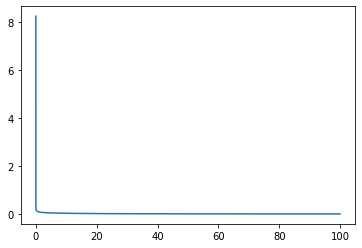

In [101]:
import matplotlib.pyplot as plt

x = np.linspace(1e-06, 100, 10000)

log_mean = 2.8
log_var = 6.0
alpha = np.exp(2.0*log_mean - log_var)
beta = np.exp(log_mean - log_var)
# alpha = 10.0
# beta = 0.1

dist = tfp.distributions.Gamma(alpha, beta, validate_args=True)
print(dist.concentration, dist.rate)

y = dist.prob(x)
log_p = dist.log_prob(x)
print(log_p)

plt.plot(x, y)

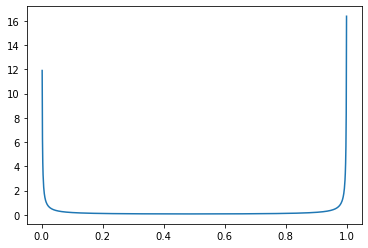

In [102]:
x = np.linspace(0.0, 1.0, 1000)

log_mean = 1.0
log_v = 0.1
alpha = log_v / (1.0 + tf.math.exp(-log_mean))
beta = log_v / (1.0 + tf.math.exp(log_mean))

dist = tfp.distributions.Beta(alpha, beta, validate_args=True)

y = dist.prob(x)
log_p = dist.log_prob(x)

plt.plot(x, y)